In [1]:
import numpy as np
import dgl
import wass_dis
import networkx as nx
import matplotlib.pyplot as plt
import signature
import ot

from signature import WKS
from signature import get_sample4WKS

from signature import HKS
from signature import get_random_samples_based_exp_dual


def Wass_WKS(glist):
    return wass_dis.pairwise_wasserstein_distance(glist,800,signature_method=WKS,sample_method=get_sample4WKS,weight=[0.4],sinkhorn=False)

def Wass_HKS(glist):
    return wass_dis.pairwise_wasserstein_distance(glist,800,signature_method=HKS,sample_method=get_random_samples_based_exp_dual,weight=[0.4],sinkhorn=False)


Using backend: pytorch[15:22:19] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/ricardo/miniconda3/envs/myenv/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.so: cannot open shared object file: No such file or directory



In [2]:
data = dgl.data.LegacyTUDataset('PTC_MR')
graphs, y = zip(*[graph for graph in data])
graphs = list(graphs)
y = np.array([unit.item() for unit in y])
Reds = plt.cm.get_cmap('Reds', 8)

First Randomly select one graph $g_1$ from the PTC_MR dataset

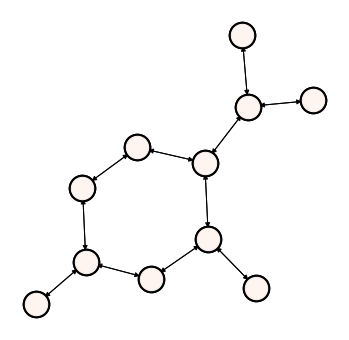

In [3]:
g1 = graphs[11]
G1 = dgl.to_networkx(g1)
plt.figure(figsize=[6,6])
ax = plt.gca()
pos = nx.kamada_kawai_layout(G1)
nx.draw(G1,pos=pos,node_color = [Reds((0.05))],node_size=500)
for node, (x, y) in pos.items():
    scatters = plt.scatter(x, y,s=510,marker='o',linewidths=5, c='white',edgecolors='black')
    ax.add_artist(scatters)
plt.show() 

In [4]:
print(f'The number of nodes in this graph is {g1.num_nodes()}')
hks_sig = signature.HKS(g1,signature.get_random_samples_based_exp_dual,800)
print('Since we set the node embeding dimension to 800')
print(f'The shape of the node embedings matrix of the given graph should be {hks_sig.shape}')

The number of nodes in this graph is 11
Since we set the node embeding dimension to 800
The shape of the node embedings matrix of the given graph should be (11, 800)


The node distance matrix between $g_1$ and $g_1$ should be one $11\times 11$ matrix, since there are 11 nodes in $g_1$, and all the diagional elements would be zero, the each elements in this matrix denote the cost of transporting one node to one other node 

In [5]:
node_distance_matrix = ot.dist(
    signature.HKS(g1,signature.get_random_samples_based_exp_dual,800), 
    signature.HKS(g1,signature.get_random_samples_based_exp_dual,800), 
    metric='sqeuclidean'
)
print(f'The shape of node distance matrix is {node_distance_matrix.shape}')
np.set_printoptions(linewidth=np.inf)
print('Here is the node distance matrix between nodes of g1 and nodes of g1')
print (np.array_str(node_distance_matrix, precision=2, suppress_small=True))

The shape of cost matric is (11, 11)
Here is the detail cost matric
[[ 0.   24.62 24.62  0.32  3.38  3.4   0.01 24.58  3.12  0.06 24.5 ]
 [24.62  0.    0.   28.56 10.49 10.34 25.08  0.   11.32 26.17  0.  ]
 [24.62  0.    0.   28.56 10.49 10.34 25.08  0.   11.32 26.17  0.  ]
 [ 0.32 28.56 28.56  0.    4.55  4.62  0.22 28.51  4.12  0.1  28.4 ]
 [ 3.38 10.49 10.49  4.55  0.    0.    3.47 10.45  0.02  3.77 10.37]
 [ 3.4  10.34 10.34  4.62  0.    0.    3.5  10.3   0.04  3.82 10.23]
 [ 0.01 25.08 25.08  0.22  3.47  3.5   0.   25.04  3.18  0.03 24.95]
 [24.58  0.    0.   28.51 10.45 10.3  25.04  0.   11.29 26.12  0.  ]
 [ 3.12 11.32 11.32  4.12  0.02  0.04  3.18 11.29  0.    3.44 11.2 ]
 [ 0.06 26.17 26.17  0.1   3.77  3.82  0.03 26.12  3.44  0.   26.02]
 [24.5   0.    0.   28.4  10.37 10.23 24.95  0.   11.2  26.02  0.  ]]


Thus obviously the transport plan with minimum cost would be one diagonal matric with all diagonal elements equals to $\frac{1}{11}$, 

because we associate $g_1$ with one uniform distribution, each node would be associate one probility equals to $\frac{1}{11}$ 

In [6]:
print('The cost plan would be')
transport_plan_matrix = np.diag(np.full(11,1/11))
print(transport_plan_matrix)

The cost plan would be
[[0.09090909 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.09090909 0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.09090909 0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.09090909 0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.09090909 0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.09090909 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.09090909 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.09090909 0.         0.      

Thus the distance between $g_1$ and $g_1$ could be calculated from sum of element-wise multiply between cost matric and transport plan matric

In [7]:
gwd = np.sum(np.multiply(node_distance_matrix,transport_plan_matrix).reshape(-1))
print(f'The graph wasserstein distance between g1 and g1 would be {np.round(gwd)}')

The graph wasserstein distance between g1 and g1 would be 0.0


Here we construct the one graph dataset with only two same graph, namely a list [g,g]
Since there are only 2 same graphs, the  **calculated wasserstein distance matric** calculated should be one **(2,2) matric** 
with all elements equal to **zero**, lets check it

In [8]:
print(Wass_HKS([g1,g1]))

[array([[0.00000000e+00, 1.29189588e-14],
       [1.29189588e-14, 0.00000000e+00]])]


**all the diagonal element would be alway zero**, since the wasserstein distance of one graph between it self should always equals to zero, lets check it

First we would also randomly select one graph $g_2$ from PTC_MR dataset

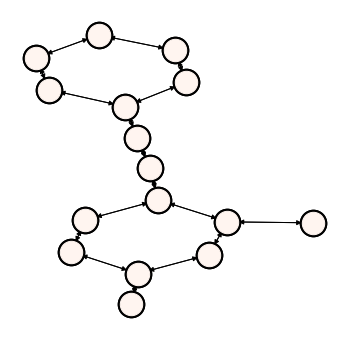

In [9]:
g2 = graphs[9]
G2 = dgl.to_networkx(g2)
plt.figure(figsize=[6,6])
ax = plt.gca()
pos = nx.kamada_kawai_layout(G2)
nx.draw(G2,pos=pos,node_color = [Reds((0.05))],node_size=500)
for node, (x, y) in pos.items():
    scatters = plt.scatter(x, y,s=510,marker='o',linewidths=5, c='white',edgecolors='black')
    ax.add_artist(scatters)
plt.show() 

In [10]:
print('the calculated wasserstein distance of this graph list is')
print(Wass_HKS([g1,g2]))

the calculated wasserstein distance of this graph list is
[array([[0.        , 0.66461819],
       [0.66461819, 0.        ]])]


As we assume above, the diagonal elements are zero, 
and the matric is symmetric, because Wasserstein distance satisfy the symmetric property